In [12]:
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Embedding, regularizers
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.merge import Concatenate
from keras import optimizers
from keras.preprocessing import sequence
from keras import backend as K
from w2v import train_word2vec 
import pickle, datetime
import numpy as np
import difflib

# ------------------------------- Data Preprocessing -----------------------------------

### Phrase -> index

In [2]:
phr_to_ind = dict()

with open('../../Datasets/SST1_dataset/dictionary.txt') as f:
    for line in f:
        entry = line.split('|')
        phr_to_ind[entry[0]] = int(entry[1])

keys = phr_to_ind.keys();

print(len(phr_to_ind), phr_to_ind['Good'])

239232 14058


### Getting Index corresponding to sentences

In [3]:
# Without doing the below computation directly load the stored output
sentence_list = []
sentiment = []

with open('../../Datasets/SST1_dataset/SentenceWithCorrection.txt') as f:
    for line in f:
        sent = line[:-1]
        sentence_list.append(sent)
        sentiment.append(phr_to_ind[sent])

print(len(sentence_list))

11855


In [4]:
# sentence_list = []
# sentiment = []

# with open('../../Datasets/SST1_dataset/datasetSentences.txt') as f:
#     f.readline()
#     for line in f:
#         entry = line.split('\t')
#         sent = entry[1][:-1]
#         sent = sent.replace('-LRB-', '(')
#         sent = sent.replace('-RRB-', ')')
    
#         if sent in phr_to_ind.keys():
#             sentiment.append(phr_to_ind[sent])
#         else:
#             print('.', end="")
#             keys_subset = [k for k in keys if (k[0] == sent[0])]
#             key = difflib.get_close_matches(sent, keys_subset, n=1);
#             sent = key[0]
#             sentiment.append(phr_to_ind[sent])
            
#         sentence_list.append(sent)
        
# print(len(sentence_list))

# # Written the output in a file
# f = open('../../Datasets/SST1_dataset/SentenceWithCorrection.txt', 'w')
# for sent in sentence_list:
#     f.write(sent + '\n')
# f.close()

### Phrase Index -> Sentiment

In [5]:
ind_to_senti = dict()

with open('../../Datasets/SST1_dataset/sentiment_labels.txt') as f:
    f.readline()
    for line in f:
        entry = line.split('|')
        ind_to_senti[int(entry[0])] = float(entry[1])

print(len(ind_to_senti))

239232


### Loading train, test and valid split info

In [6]:
split_ind = []
with open('../../Datasets/SST1_dataset/datasetSplit.txt') as f:
    f.readline()
    for line in f:
        entry = line.split(',')
        split_ind.append(int(entry[1]))

print(len(split_ind))

for i in range(len(split_ind)):
    if split_ind[i] == 3:
        split_ind[i] = 1
        
N_train = split_ind.count(1)
N_test = split_ind.count(2)
N_valid = split_ind.count(3)
print (N_train, N_test, N_valid)

11855
9645 2210 0


### Assigning label to sentences

In [7]:
N_sent = len(sentence_list);
N_category = 5

y_label = []

for ind in sentiment:
    val = ind_to_senti[ind]
    if val >= 0.0 and val <= 0.2:
        y_label.append(0);
    elif val > 0.2 and val <= 0.4:
        y_label.append(1)
    elif val > 0.4 and val <= 0.6:
        y_label.append(2)
    elif val > 0.6 and val <= 0.8:
        y_label.append(3)
    else:
        y_label.append(4)

print(y_label.count(0), y_label.count(1), y_label.count(2), y_label.count(3))

# Labels in one-hot encoding
y_train = np.zeros((N_train, N_category), np.uint8)
y_test  = np.zeros((N_test , N_category), np.uint8)
y_valid = np.zeros((N_valid, N_category), np.uint8)

c1,c2,c3 = 0,0,0
for i in range(len(y_label)):
    label = y_label[i]
    if split_ind[i] == 1:
        y_train[c1, label] = 1;  c1 += 1
    elif split_ind[i] == 2:
        y_test [c2, label] = 1;  c2 += 1
    else:
        y_valid[c3, label] = 1;  c3 += 1

1510 3140 2242 3111


### Reducing the size of vocabulary

In [8]:
x_all = []
max_sent_len = -1;
max_wrd_len = -1
wrd_to_ind = dict()

ind_new = 1;
for sent in sentence_list:
    wrds = sent.split()
    vec = []
    for wrd in wrds:
        if wrd not in wrd_to_ind.keys():
            wrd_to_ind[wrd] = ind_new
            ind_new += 1
            
        ind = wrd_to_ind[wrd]
        vec.append(ind)
            
    max_sent_len = max(len(vec), max_sent_len)
    x_all.append(vec)

# Get inverse dictionary
ind_to_wrd = dict((v, k) for k, v in wrd_to_ind.items())
ind_to_wrd[0] = "<PAD/>"

print(len(phr_to_ind), len(wrd_to_ind))

239232 21699


### Create input features

In [9]:
# x_train = np.zeros((N_train, max_sent_len), np.int32)
# x_test  = np.zeros((N_test,  max_sent_len), np.int32)
# x_valid = np.zeros((N_valid, max_sent_len), np.int32)
x_train = []
x_test = []
x_valid = []

c1, c2, c3 = 0,0,0
for i in range(len(x_all)):
    vec = x_all[i]
    if split_ind[i] == 1:
        x_train.append(vec)
#         x_train[c1,0:len(vec)] = np.int32(vec); 
        c1 += 1
    elif split_ind[i] == 2:
        x_test.append(vec)
        x_test [c2,0:len(vec)] = np.int32(vec); 
        c2 += 1
    else:
        x_valid.append(vec)
        x_valid[c3,0:len(vec)] = np.int32(vec); 
        c3 += 1

print(c1, c2, c3)

9645 2210 0


In [13]:
x_train = sequence.pad_sequences(x_train, maxlen=max_sent_len, padding="post", truncating="post")
x_test = sequence.pad_sequences(x_test, maxlen=max_sent_len, padding="post", truncating="post")

# -------------------------------- Training model  -----------------------------------

### Model Paremeters

In [11]:
model_type    = 'CNN-rand'  # CNN-rand|CNN-non-static|CNN-static
embedding_dim = 10         # word2vec dim
vocab_size    = len(ind_to_wrd)

### Generate word2vec 

In [12]:
if model_type in ['CNN-non-static', 'CNN-static']:
    embedding_wts = train_word2vec( np.vstack((x_train, x_test, x_valid)), 
                                    ind_to_wrd, num_features = embedding_dim)
    if model_type == 'CNN-static':
        x_train = embedding_wts[0][x_train]
        x_test  = embedding_wts[0][x_test]
#         x_valid = embedding_wts[0][x_valid]
        
elif model_type == 'CNN-rand':
    embedding_wts = None
    
else:
    raise ValueError("Unknown model type")

### Create model

In [13]:
batch_size   = 10
filter_sizes = [3,4,5]
num_filters  = 10
dropout_prob = (0.5, 0.8)
hidden_dims  = 10

l2_reg = 0.3

# Deciding dimension of input based on the model
input_shape = (max_sent_len, embedding_dim) if model_type == "CNN-static" else (max_sent_len,)
model_input = Input(shape = input_shape)

# Static model do not have embedding layer
if model_type == "CNN-static":
    z = Dropout(dropout_prob[0])(model_input)
else:
    z = Embedding(vocab_size, embedding_dim, input_length = max_sent_len, name="embedding", trainable=True)(model_input)
    z = Dropout(dropout_prob[0])(z)

# Convolution layers
z1 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[0], 
                padding="valid", activation="relu", 
                strides=1)(z)
z1 = MaxPooling1D(pool_size = max_sent_len - filter_sizes[0] +1)(z1)
z1 = Flatten()(z1)

z2 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[1], 
                padding="valid", activation="relu", 
                strides=1)(z)
z2 = MaxPooling1D(pool_size=max_sent_len - filter_sizes[1] +1)(z2)
z2 = Flatten()(z2)

z3 = Conv1D(    filters=num_filters, kernel_size=filter_sizes[2], 
                padding="valid", activation="relu",
                strides=1)(z)
z3 = MaxPooling1D(pool_size=max_sent_len - filter_sizes[2] +1)(z3)
z3 = Flatten()(z3)

# Concatenate the output of all convolution layers
z = Concatenate()([z1, z2, z3])
z = Dropout(dropout_prob[1])(z)

z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(N_category, activation="softmax")(z)
    
model = Model(model_input, model_output)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 56)            0                                            
____________________________________________________________________________________________________
embedding (Embedding)            (None, 56, 10)        217000                                       
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 56, 10)        0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 54, 10)        310                                          
___________________________________________________________________________________________

### Train model 

In [16]:
if model_type == "CNN-non-static":
    embedding_layer = model.get_layer("embedding")
    embedding_layer.set_weights(embedding_wts)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(), metrics=["accuracy"])

res = model.fit(x_train, y_train, 
          batch_size = batch_size,
          epochs=100,
          validation_data=(x_test, y_test), verbose=2)

Train on 9645 samples, validate on 2210 samples
Epoch 1/100
13s - loss: 1.5686 - acc: 0.2648 - val_loss: 1.5740 - val_acc: 0.2842
Epoch 2/100
15s - loss: 1.5632 - acc: 0.2734 - val_loss: 1.5719 - val_acc: 0.2534
Epoch 3/100
10s - loss: 1.5551 - acc: 0.2942 - val_loss: 1.5561 - val_acc: 0.3140
Epoch 4/100
8s - loss: 1.5376 - acc: 0.3119 - val_loss: 1.5313 - val_acc: 0.3109
Epoch 5/100
7s - loss: 1.5105 - acc: 0.3346 - val_loss: 1.5078 - val_acc: 0.3226
Epoch 6/100
7s - loss: 1.4714 - acc: 0.3532 - val_loss: 1.4500 - val_acc: 0.3606
Epoch 7/100
8s - loss: 1.4241 - acc: 0.3805 - val_loss: 1.4236 - val_acc: 0.3833
Epoch 8/100
8s - loss: 1.3848 - acc: 0.3973 - val_loss: 1.4109 - val_acc: 0.3615
Epoch 9/100
8s - loss: 1.3489 - acc: 0.4048 - val_loss: 1.3993 - val_acc: 0.3796
Epoch 10/100
7s - loss: 1.3233 - acc: 0.4177 - val_loss: 1.3939 - val_acc: 0.3665
Epoch 11/100
7s - loss: 1.2922 - acc: 0.4300 - val_loss: 1.3934 - val_acc: 0.3701
Epoch 12/100
7s - loss: 1.2754 - acc: 0.4405 - val_loss:

In [22]:
import os
os.system('say done')

256

### Computing Accuracy

In [17]:
# Training Accuracy
predictions = model.predict(x_train)
pred_train = np.argmax(predictions, axis=1)
train_label = np.argmax(y_train, axis=1)
print('Training Accuracy', np.sum(pred_train == train_label) / N_train * 100)

# # Training Accuracy
# predictions = model.predict(x_valid)
# pred_valid = np.argmax(predictions, axis=1)
# valid_label = np.argmax(y_valid, axis=1)
# print('Validation Accuracy', np.sum(pred_valid == valid_label) / N_valid * 100)

# Test Accuracy
predictions = model.predict(x_test)
pred_test = np.argmax(predictions, axis=1)
test_label = np.argmax(y_test, axis=1)
print('Testing Accuracy', np.sum(pred_test == test_label) / N_test * 100)

Training Accuracy 75.0855365474
Testing Accuracy 28.0995475113


### Save the model

In [18]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = '/home/shikhar/Datasets/Models/review_' + model_type + '_' + date + '_' +time;
with open( filename, 'wb') as output:
    pickle.dump([model.get_config(), model.get_weights(), model.history.history], output, pickle.HIGHEST_PROTOCOL)

### Plot the results

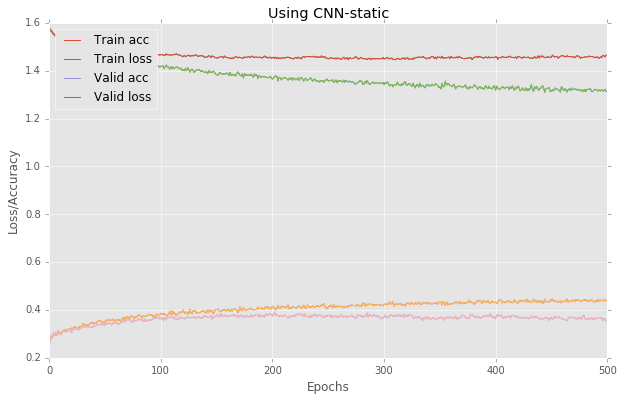

In [15]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = (10,6)
plt.plot(res.history['acc'])
plt.plot(res.history['loss'])
plt.plot(res.history['val_acc'])
plt.plot(res.history['val_loss'])
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using '+ model_type)
# imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
# plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()

### Continue from a pretrained model

In [19]:
# Loading saved data
import pickle

# filename = '/home/shikhar/Datasets/Models/3_CNN-static_2017-04-04_11:38:41'
with open( filename, 'rb') as input:
    out = pickle.load(input)

model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(), metrics=["accuracy"])
model.set_weights(out[1])

In [20]:
res = model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs=300,
          validation_data=(x_test, y_test), verbose=2)

Train on 9645 samples, validate on 2210 samples
Epoch 1/300
7s - loss: 0.8510 - acc: 0.6471 - val_loss: 1.8517 - val_acc: 0.2833
Epoch 2/300
7s - loss: 0.8565 - acc: 0.6406 - val_loss: 1.8470 - val_acc: 0.2828
Epoch 3/300
8s - loss: 0.8558 - acc: 0.6443 - val_loss: 1.8830 - val_acc: 0.2792
Epoch 4/300
7s - loss: 0.8578 - acc: 0.6410 - val_loss: 1.9108 - val_acc: 0.2765
Epoch 5/300
7s - loss: 0.8615 - acc: 0.6434 - val_loss: 1.8636 - val_acc: 0.2774
Epoch 6/300
7s - loss: 0.8436 - acc: 0.6496 - val_loss: 1.8704 - val_acc: 0.2783
Epoch 7/300
7s - loss: 0.8492 - acc: 0.6497 - val_loss: 1.8681 - val_acc: 0.2733
Epoch 8/300
7s - loss: 0.8578 - acc: 0.6459 - val_loss: 1.8697 - val_acc: 0.2801
Epoch 9/300
7s - loss: 0.8479 - acc: 0.6453 - val_loss: 1.8526 - val_acc: 0.2760
Epoch 10/300
7s - loss: 0.8459 - acc: 0.6486 - val_loss: 1.8848 - val_acc: 0.2810
Epoch 11/300
8s - loss: 0.8564 - acc: 0.6504 - val_loss: 1.8689 - val_acc: 0.2697
Epoch 12/300
7s - loss: 0.8373 - acc: 0.6554 - val_loss: 1.

### Save the model (marking as continued)

In [24]:
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]

filename = '/home/shikhar/Datasets/Models/' + model_type + '_continued_' + date + '_' +time;
with open( filename, 'wb') as output:
    pickle.dump([model.get_config(), model.get_weights(), model.history.history], output, pickle.HIGHEST_PROTOCOL)

In [23]:
import os
os.system('say done')

256

In [24]:
files = [
    'CNN-rand_continued_2017-04-02_19:26:35',
    'CNN-rand_continued_2017-04-03_16:50:47',
    'CNN-rand_continued_2017-04-03_17:18:47'
]

In [25]:
train_acc, train_loss, val_acc, val_loss = [],[],[],[]

for file in files:
    filename = '/home/shikhar/Datasets/Models/'  + file
    with open( filename, 'rb') as input:
        out = pickle.load(input)
    train_acc += out[2]['acc']
    train_loss += out[2]['loss']
    val_acc += out[2]['val_acc']
    val_loss += out[2]['val_loss']

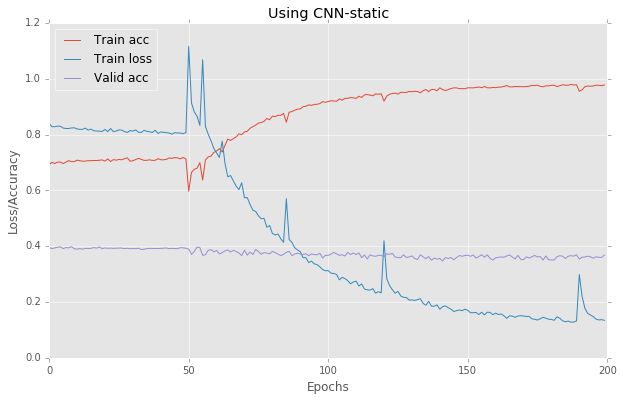

In [35]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(train_acc)
plt.plot(train_loss)
plt.plot(val_acc)
# plt.plot(val_loss)
plt.legend(['Train acc','Train loss','Valid acc', 'Valid loss'], loc=2)
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('Using '+ model_type)
date = str(datetime.date.today() )
time = str(datetime.datetime.now().time())[:-7]
imgName = 'Images/' + model_type + '_' + date + '_' + time + '.jpg'
plt.savefig( imgName, dpi= 200, bbox_inches='tight', transparent=False)
plt.show()